In [1]:
import os
import random as rnd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchaudio
import torch.nn as nn
from torch.nn.functional import normalize
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchaudio.prototype.models
import torchaudio.prototype.pipelines
import torch.nn.functional as F

In [2]:
import classes.ProjectClasses as pcl

In [3]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
ANNOTATIONS_FILE_TRAIN = "train_data/metadata/file_labels.csv"
AUDIO_DIR_TRAIN = "train_data/files"
ANNOTATIONS_FILE_VAL = "valid_data/metadata/file_labels.csv"
AUDIO_DIR_VAL = "valid_data/files"
SAMPLE_RATE = 10000
NUM_SAMPLES = 9600

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate = SAMPLE_RATE,
    n_fft = 400,
    hop_length = 160,
    n_mels = 64
)

spr_train = pcl.SpikerboxRecordings(
    ANNOTATIONS_FILE_TRAIN,
    AUDIO_DIR_TRAIN,
    mel_spectrogram,
    SAMPLE_RATE,
    NUM_SAMPLES,
    device,
    1
)
spr_valid = pcl.SpikerboxRecordings(
    ANNOTATIONS_FILE_VAL,
    AUDIO_DIR_VAL,
    mel_spectrogram,
    SAMPLE_RATE,
    NUM_SAMPLES,
    device,
    1
)

In [5]:
torch.cuda.empty_cache()
BATCH_SIZE = 128
EPOCHS = 7
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.01

generator = torch.Generator()
generator.manual_seed(569567390)
train_dl = DataLoader(spr_train, batch_size = BATCH_SIZE, shuffle = True, generator = generator)
val_dl = DataLoader(spr_valid, batch_size = BATCH_SIZE, shuffle = False, generator = generator)

VGGish_Grade = pcl.VGGishNetwork(20).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.AdamW(VGGish_Grade.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)

stats = pcl.TrainUtils(20).train(VGGish_Grade, train_dl, val_dl, optimizer, loss_fn, EPOCHS, device)

KeyboardInterrupt: 

In [ ]:
torch.save(VGGish_Grade.state_dict(), "trained_models/VGGish_Grade.pth")

In [25]:
print(stats)

[[1.9815909, 1.296803, 0.9286406, 0.789064, 0.687035, 0.5706048, 0.4892557], [23.0, 44.0, 56.00000000000001, 63.0, 68.0, 74.0, 78.0], [90.16, 91.98, 93.02, 94.23, 95.07, 96.08, 96.74], [2.6953803, 3.3724426, 4.1313208, 3.6794545, 5.5500135, 6.0093395, 6.4373764], [25.0, 17.0, 22.0, 21.0, 21.0, 25.0, 19.0], [91.31, 91.75, 92.27, 92.46, 92.77, 91.49, 91.57]]


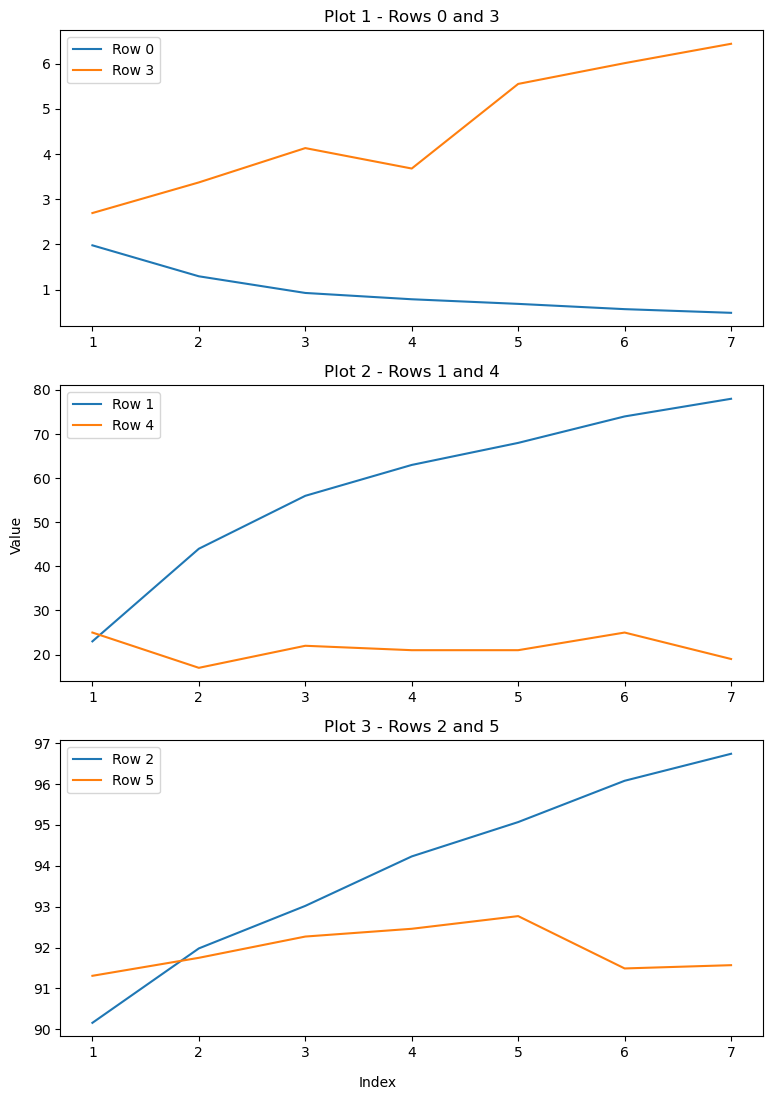

In [31]:
fig, axes = plt.subplots(3, 1, figsize=(8, 12))
epoch_ticks = np.arange(1, len(stats)+2)
# Plot rows 0 and 3 in the first subplot
axes[0].plot(epoch_ticks, stats[0], label='Row 0')
axes[0].plot(epoch_ticks, stats[3], label='Row 3')
axes[0].set_title('Plot 1 - Rows 0 and 3')
axes[0].legend()
axes[0].set_xticks(epoch_ticks)

# Plot rows 1 and 4 in the second subplot
axes[1].plot(epoch_ticks, stats[1], label='Row 1')
axes[1].plot(epoch_ticks, stats[4], label='Row 4')
axes[1].set_title('Plot 2 - Rows 1 and 4')
axes[1].legend()
axes[1].set_xticks(epoch_ticks)

# Plot rows 2 and 5 in the third subplot
axes[2].plot(epoch_ticks, stats[2], label='Row 2')
axes[2].plot(epoch_ticks, stats[5], label='Row 5')
axes[2].set_title('Plot 3 - Rows 2 and 5')
axes[2].legend()
axes[2].set_xticks(epoch_ticks)

fig.text(0.5, 0.04, 'Index', ha='center')
fig.text(0.04, 0.5, 'Value', va='center', rotation='vertical')

# Adjust layout
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])

# Show the plots
plt.show()